# Fingerprint distances between structures for the same kinase

We investigate the ranges of fingerprint distances for each kinase pair:

- Compare the fingerprint distance distribution for intra-kinase pairs and inter-kinase pairs
- For the kinase pairs with highest structure pair coverage, show the range of fingerprint distances (consider minimum or median for structure-to-kinase mapping)
- Generate `kissim` kinase matrix for kinase subset investigated in the paper ["Analyzing Kinase Similarity in Small Molecule and Protein Structural Space to Explore the Limits of Multi-Target Screening"](https://www.mdpi.com/1420-3049/26/3/629)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/all"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = DATA / "fingerprint_distances.csv"

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)

In [10]:
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 279
Number of structures: 4681


In [11]:
structure_distances = fingerprint_distance_generator.data
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,1,4,EphA7,EphA7,0.011780,0.961333
1,1,8,EphA7,ITK,0.067187,0.946000
2,1,9,EphA7,ITK,0.095289,0.961333
3,1,11,EphA7,ITK,0.073468,0.961333
4,1,12,EphA7,ITK,0.067586,0.946000


### Add DFG conformation

In [12]:
def get_dfg(dfg, structure_klifs_id):
    try:
        return dfg[structure_klifs_id] 
    except KeyError:
        return None

In [13]:
%%time
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: get_dfg(dfg, x))
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: get_dfg(dfg, x))

CPU times: user 55.5 s, sys: 279 ms, total: 55.8 s
Wall time: 55.8 s


### Filter distances by coverage cutoff

#### All conformation pairs

In [14]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2,distance_filtered
0,1,4,EphA7,EphA7,0.011780,0.961333,out,in,0.011780
1,1,8,EphA7,ITK,0.067187,0.946000,out,in,0.067187
2,1,9,EphA7,ITK,0.095289,0.961333,out,in,0.095289
3,1,11,EphA7,ITK,0.073468,0.961333,out,in,0.073468
4,1,12,EphA7,ITK,0.067586,0.946000,out,in,0.067586


In [15]:
structure_distances_filtered = structure_distances[
    structure_distances["distance_filtered"].notna()
]

In [16]:
print(f"Structure pairs: {structure_distances.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered.shape[0]}")

Structure pairs: 10953540
Structure pairs not-NaN: 10948918


#### DFG-in conformation pairs

In [17]:
%%time
# Select DFG-in only

# Without coverage cutoff
structure_distances_in_in = structure_distances[
    structure_distances.apply(lambda x: x["dfg.1"] == x["dfg.2"] == "in", axis=1)
]
# With coverage cutoff
structure_distances_filtered_in_in = structure_distances_filtered[
    structure_distances_filtered.apply(lambda x: x["dfg.1"] == x["dfg.2"] == "in", axis=1)
]

CPU times: user 2min 33s, sys: 2.45 s, total: 2min 36s
Wall time: 2min 36s


In [18]:
print(f"Structure pairs: {structure_distances_in_in.shape[0]}")
print(f"Structure pairs not-NaN: {structure_distances_filtered_in_in.shape[0]}")

Structure pairs: 8374278
Structure pairs not-NaN: 8371955


## Structure distances

### Structure distance distributions for different kinase subsets

- DFG-in pairs only!!!
- With cutoff!!!
- All structure distances
- Structure distances between the same kinases
- Structure distances between different kinases

In [19]:
structure_distances_df.notna().sum()

NameError: name 'structure_distances_df' is not defined

NameError: name 'structure_distances_df' is not defined

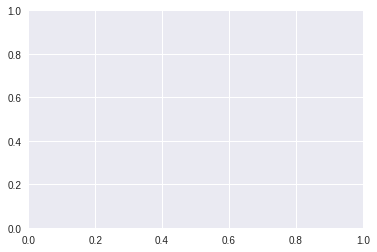

In [20]:
fig, ax = plt.subplots(1, 1)
structure_distances_df.plot(kind="box", ax=ax)
ax.set_xlabel("Type of kinase pairs")
ax.set_ylabel("Structure pair distances (DFG-in only)")
fig.savefig(
    HERE / "../../notebooks/figures/kissim_discriminating_kinases.png",
    dpi=300,
    bbox_inches="tight",
)

In [21]:
structure_distances_df.describe()

NameError: name 'structure_distances_df' is not defined

In [22]:
structure_distances_filtered_in_in_df = pd.DataFrame(
    {
        "all": structure_distances_filtered_in_in["distance"],
        "intra-kinase": structure_distances_filtered_in_in[
            structure_distances_filtered_in_in["kinase.1"] == structure_distances_filtered_in_in["kinase.2"]
        ]["distance"],
        "inter-kinase": structure_distances_filtered_in_in[
            structure_distances_filtered_in_in["kinase.1"] != structure_distances_filtered_in_in["kinase.2"]
        ]["distance"],
    }
)

In [23]:
structure_distances_filtered_in_in_df.notna().sum()

all             8371955
intra-kinase     198339
inter-kinase    8173616
dtype: int64

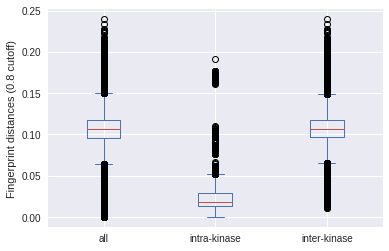

In [24]:
fig, axes = plt.subplots(1, 1)
structure_distances_filtered_in_in_df.plot(kind="box", ax=axes)
axes.set_ylabel(f"Fingerprint distances ({COVERAGE_CUTOFF} cutoff)")
fig.savefig(HERE / "../../notebooks/figures/kissim_discriminates_kinases.png", dpi=300)

In [25]:
structure_distances_filtered_in_in_df.describe()

,all,intra-kinase,inter-kinase
count,8.371955e+06,198339.000000,8.173616e+06
mean,1.070813e-01,0.021379,1.091610e-01
std,2.456204e-02,0.010801,2.079774e-02
min,0.000000e+00,0.000000,1.028263e-02
25%,9.586968e-02,0.013727,9.672978e-02
50%,1.061391e-01,0.018029,1.065845e-01
75%,1.173430e-01,0.029011,1.176966e-01
max,2.394582e-01,0.191790,2.394582e-01


### Per kinase distributions

How robust are structure distances within kinase pairs?

#### All kinase pairs

In [26]:
data = structure_distances_filtered[["kinase.1", "kinase.2", "distance"]].groupby(
    ["kinase.1", "kinase.2"]
)

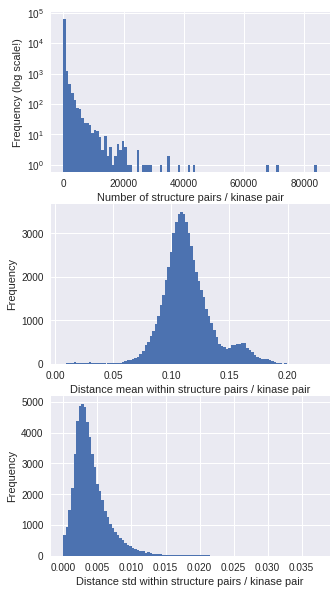

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
# Size
data.size().plot(ax=axes[0], kind="hist", logy=True, style=".", bins=100)
axes[0].set_xlabel("Number of structure pairs / kinase pair")
axes[0].set_ylabel("Frequency (log scale!)")
# Mean
data.mean().squeeze().plot(ax=axes[1], kind="hist", style=".", bins=100)
axes[1].set_xlabel("Distance mean within structure pairs / kinase pair")
# Std
data.std().squeeze().plot(ax=axes[2], kind="hist", logy=False, style=".", bins=100)
axes[2].set_xlabel("Distance std within structure pairs / kinase pair");

In [28]:
print("size == 1: ", data.size()[data.size() == 1].shape[0])
print("size < 5: ", data.size()[data.size() < 5].shape[0])
print("size < 10: ", data.size()[data.size() < 10].shape[0])
print("size < 100: ", data.size()[data.size() < 100].shape[0])
print("size < 1000: ", data.size()[data.size() < 1000].shape[0])
print("size < 10000: ", data.size()[data.size() < 10000].shape[0])
print("size: ", data.size().shape[0])

size == 1:  4024
size < 5:  15186
size < 10:  23272
size < 100:  49370
size < 1000:  60516
size < 10000:  62468
size:  62560


In [29]:
data.mean().describe()

,distance
count,62560.000000
mean,0.113549
std,0.022761
min,0.006864
25%,0.100695
50%,0.111052
75%,0.123832
max,0.225433


In [30]:
data.std().describe()

,distance
count,58536.000000
mean,0.004115
std,0.002725
min,0.000001
25%,0.002362
50%,0.003489
75%,0.005145
max,0.037247


#### Most frequent kinase pairs (all conformations)

In [31]:
data = structure_distances_filtered.groupby(["kinase.1", "kinase.2"])

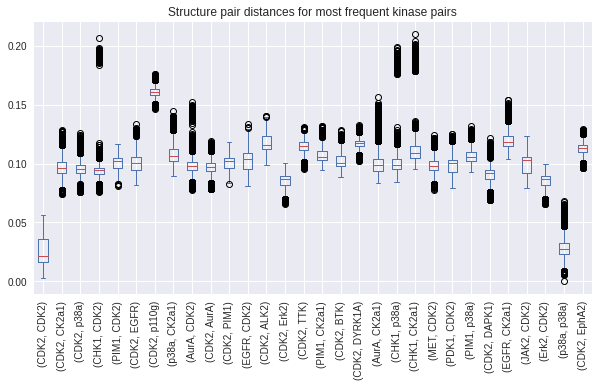

In [32]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs");

In [33]:
data_min = data.min()

/tmp/ipykernel_30895/812266529.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  data_min = data.min()


#### Most frequent kinase pairs (DFG-in conformations only)

In [34]:
data = structure_distances_filtered_in_in.groupby(["kinase.1", "kinase.2"])

<AxesSubplot:>

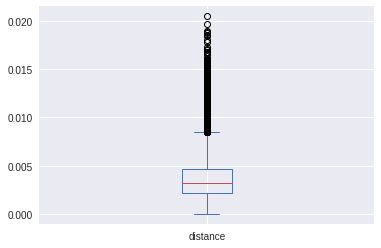

In [35]:
data["distance"].std().plot(kind="box")

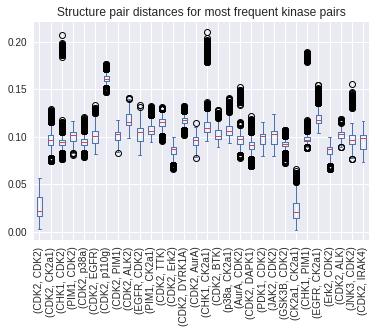

In [36]:
ntop = 30
index = data.size().sort_values(ascending=False).head(ntop).index
top_pair_distances = {pair: data.get_group(pair)["distance"] for pair in index}
top_pair_distances = pd.DataFrame(top_pair_distances)
fig, axes = plt.subplots(1, 1)
top_pair_distances.plot(kind="box", ax=axes, rot=90)
axes.set_title("Structure pair distances for most frequent kinase pairs")
fig.savefig(
    HERE / f"../../notebooks/figures/figX_structure_distances_per_kinase_pair_top{ntop}.pdf",
    bbox_inches="tight",
)

## Kinase matrix

### All distances

NameError: name 'kinase_distances' is not defined

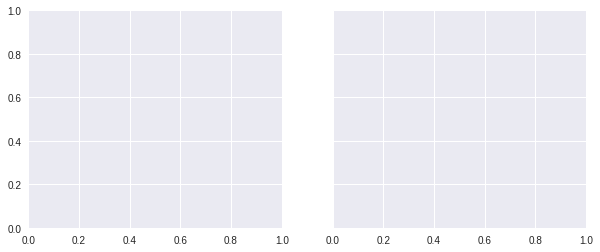

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[0])
axes[0].set_title("All distances")
kinase_matrix = kinase_distances.pivot("kinase.1", "kinase.2", "distance_filtered")
sns.heatmap(kinase_matrix, cmap="Blues", ax=axes[1])
axes[1].set_title("Only distances for pairs matching coverage cutoff");

In [38]:
def n_pairs(n):
    return int((n ** 2 - n) / 2 + n)

In [39]:
n_structures = (
    pd.concat([structure_distances["structure.1"], structure_distances["structure.2"]])
    .unique()
    .shape[0]
)
n_kinases = (
    pd.concat([structure_distances["kinase.1"], structure_distances["kinase.2"]]).unique().shape[0]
)
n_structures_filtered = (
    pd.concat(
        [structure_distances_filtered["structure.1"], structure_distances_filtered["structure.2"]]
    )
    .unique()
    .shape[0]
)
n_kinases_filtered = (
    pd.concat([structure_distances_filtered["kinase.1"], structure_distances_filtered["kinase.2"]])
    .unique()
    .shape[0]
)


table = {
    "All distances": [
        n_structures,
        n_pairs(n_structures),
        structure_distances.shape[0],
        n_kinases,
        n_pairs(n_kinases),
        kinase_distances.shape[0],
    ],
    "Only distances matching cutoff": [
        n_structures_filtered,
        n_pairs(n_structures_filtered),
        structure_distances_filtered.shape[0],
        n_kinases_filtered,
        n_pairs(n_kinases_filtered),
        kinase_distances_filtered.shape[0],
    ],
}
table = pd.DataFrame(
    table,
    index=[
        "Number of structures",
        "Number of structure pairs (theory)",
        "Number of structure pairs (experimental)",
        "Number of kinases",
        "Number of kinase pairs (theory)",
        "Number of kinase pairs (experimental)",
    ],
)
table

NameError: name 'kinase_distances' is not defined

## Dual kinases paper dataset

https://www.mdpi.com/1420-3049/26/3/629

In [40]:
from itertools import combinations_with_replacement

In [41]:
KINASES_KLIFS_TO_PAPER = {
    "EGFR": "EGFR",
    "ErbB2": "ErbB2",
    "KDR": "VEGFR2",
    "p110a": "PI3K",
    "BRAF": "BRAF",
    "CDK2": "CDK2",
    "LCK": "LCK",
    "MET": "MET",
    "p38a": "p38a",
}

In [42]:
# All kinases
kinase_matrix = fingerprint_distance_generator.kinase_distance_matrix(coverage_min=COVERAGE_CUTOFF)
# Select kinases from paper
example_kinase_matrix = kinase_matrix.loc[KINASES_KLIFS_TO_PAPER.keys(), KINASES_KLIFS_TO_PAPER.keys()]
# Rename kinases to paper kinase names
example_kinase_matrix = example_kinase_matrix.rename(columns=KINASES_KLIFS_TO_PAPER)
example_kinase_matrix

kinase.2,EGFR,ErbB2,VEGFR2,PI3K,BRAF,CDK2,LCK,MET,p38a
kinase.1,,,,,,,,,
EGFR,0.000000,0.039648,0.068053,0.142969,0.092932,0.080826,0.075684,0.076089,0.091348
ErbB2,0.039648,0.000000,0.083884,0.161669,0.098179,0.088320,0.098872,0.086752,0.099634
KDR,0.068053,0.083884,0.000000,0.150364,0.085402,0.083035,0.078523,0.062961,0.083357
p110a,0.142969,0.161669,0.150364,0.000000,0.130396,0.143338,0.144332,0.152306,0.141210
BRAF,0.092932,0.098179,0.085402,0.130396,0.000000,0.078493,0.088816,0.091530,0.097344
CDK2,0.080826,0.088320,0.083035,0.143338,0.078493,0.000000,0.077310,0.077652,0.075778
LCK,0.075684,0.098872,0.078523,0.144332,0.088816,0.077310,0.000000,0.081988,0.093458
MET,0.076089,0.086752,0.062961,0.152306,0.091530,0.077652,0.081988,0.000000,0.099564
p38a,0.091348,0.099634,0.083357,0.141210,0.097344,0.075778,0.093458,0.099564,0.000000


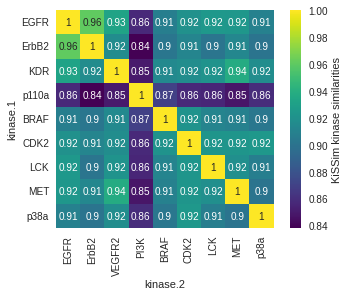

In [43]:
# Use similarities instead of distances
sns.heatmap(
    1 - example_kinase_matrix,
    linewidths=0,
    annot=True,
    square=True,
    cbar_kws={"label": "KiSSim kinase similarities"},
    cmap="viridis",
)
plt.show()

Compare to paper (shows similarities; not distances; __so think values inverse__):

![](https://www.mdpi.com/molecules/molecules-26-00629/article_deploy/html/images/molecules-26-00629-g002.png)

Figure 2. Heat maps of pairwise kinase similarities for the different measures used in this work: (A) ligand profile similarity (LigProfSim); (B) pocket sequence similarity (PocSeqSim); (C) interaction fingerprint similarity (IFPSim); (D) pocket structure similarity (PocStrucSim); and (E) docking rank similarity (DockRankSim) based on the lead-like subset of ZINC. Note that docking was only performed for the five kinases of Profiles 1–4, thus the remaining entries remain empty (white) in the matrix.